In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet

from PIL import Image
#from albumentations.pytorch import ToTensor 
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sys
import sklearn

import cv2
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from torchvision import models, transforms
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt



IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 100

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)


'''
IMAGE TRANSFORMS
'''
class ImageTransform:
    def __init__(self, size, mean, std):
        self.data_transform = transforms.Compose([
                transforms.Resize((size, size), interpolation=Image.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

    def __call__(self, img):
        return self.data_transform(img)


In [2]:
transformer = ImageTransform(IMG_SIZE, mean, std)

In [3]:
device = 'cuda'
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
model = model.to(device)

# Load the model state
deepfake_types = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

Loaded pretrained weights for efficientnet-b0


In [4]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary classification loss

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move data to the correct device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Model forward pass
            outputs = model(inputs)
            
            # Ensure outputs and labels have the same shape
            outputs = outputs.view(-1)  # Flatten outputs to match labels
            labels = labels.view(-1).float()  # Flatten labels and convert to float

            # Compute loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate predictions and accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).long()
            correct += (predictions == labels.long()).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [5]:
deepfakes_test_statistics = {}
for deepfake_type_dataset in deepfake_types:
    DEEPFAKE_TYPE = deepfake_type_dataset
    TEST_FOLDER = fr'D:\FF\crops\{DEEPFAKE_TYPE}\test' 
    test_ds = ImageFolder(root=TEST_FOLDER, transform=transformer)
    test_loader = DataLoader(test_ds, shuffle=False, batch_size=64)


    for deepfake_type_model in deepfake_types:
        model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
        model = model.to(device)
        checkpoint = torch.load(f"ff_effnet0_1fc_{deepfake_type_model}_aug.pth")
        model.load_state_dict(checkpoint["model_state"])

        avg_loss, accuracy = test_model(model, test_loader)
        print(avg_loss, accuracy)
        if deepfake_type_dataset not in deepfakes_test_statistics:
            deepfakes_test_statistics[deepfake_type_dataset] = {}
        deepfakes_test_statistics[deepfake_type_dataset][deepfake_type_model] = accuracy

Loaded pretrained weights for efficientnet-b0


C:\Users\Sheryl\AppData\Local\Temp\ipykernel_38424\2909463707.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"ff_effnet0_1fc_{deepfake_type_mo

0.3079145083458518 0.8665316227774027
Loaded pretrained weights for efficientnet-b0
0.7148094442036512 0.6344812063920774
Loaded pretrained weights for efficientnet-b0
0.8215352348822484 0.5945307224848075
Loaded pretrained weights for efficientnet-b0
1.3939252260991994 0.5005626828719334
Loaded pretrained weights for efficientnet-b0
0.5616254697171904 0.7131442718883637
Loaded pretrained weights for efficientnet-b0
1.11845925314618 0.5822002472187886
Loaded pretrained weights for efficientnet-b0
0.4087338067059006 0.8096415327564895
Loaded pretrained weights for efficientnet-b0
1.095220794794815 0.5145521968760535
Loaded pretrained weights for efficientnet-b0
1.17508840427867 0.5320822564333071
Loaded pretrained weights for efficientnet-b0
0.7085146511239665 0.6329924710641646
Loaded pretrained weights for efficientnet-b0
1.4182584977728858 0.5368432894588817
Loaded pretrained weights for efficientnet-b0
1.1642568725690567 0.49713128585892674
Loaded pretrained weights for efficientnet

In [6]:
deepfakes_test_statistics

{'Deepfakes': {'Deepfakes': 0.8665316227774027,
  'Face2Face': 0.6344812063920774,
  'FaceShifter': 0.5945307224848075,
  'FaceSwap': 0.5005626828719334,
  'NeuralTextures': 0.7131442718883637},
 'Face2Face': {'Deepfakes': 0.5822002472187886,
  'Face2Face': 0.8096415327564895,
  'FaceShifter': 0.5145521968760535,
  'FaceSwap': 0.5320822564333071,
  'NeuralTextures': 0.6329924710641646},
 'FaceShifter': {'Deepfakes': 0.5368432894588817,
  'Face2Face': 0.49713128585892674,
  'FaceShifter': 0.8252896838789515,
  'FaceSwap': 0.49679379007762403,
  'NeuralTextures': 0.6033299583755203},
 'FaceSwap': {'Deepfakes': 0.4615038777115882,
  'Face2Face': 0.5347870068562437,
  'FaceShifter': 0.4831965831179049,
  'FaceSwap': 0.8446667415982916,
  'NeuralTextures': 0.48375857030459707},
 'NeuralTextures': {'Deepfakes': 0.6291048133153396,
  'Face2Face': 0.5980656770130455,
  'FaceShifter': 0.574336482231219,
  'FaceSwap': 0.48279352226720645,
  'NeuralTextures': 0.8031938821412505}}

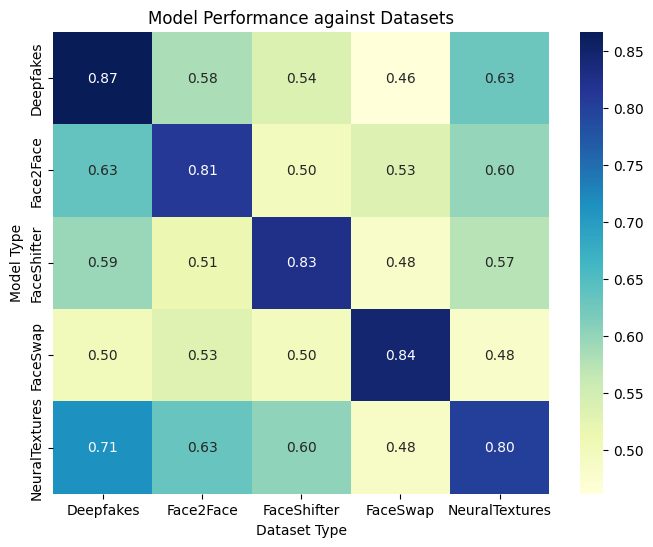

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Convert data to a numpy array for heatmap
labels = list(deepfakes_test_statistics.keys())
values = np.array([[deepfakes_test_statistics[j][i] for j in deepfake_types] for i in deepfake_types])

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(values, annot=True, cmap="YlGnBu", xticklabels=deepfake_types, yticklabels=deepfake_types, fmt=".2f")
plt.title("Model Performance against Datasets (Flip)")
plt.xlabel("Dataset Type")
plt.ylabel("Model Type")
plt.show()

# knowledge distillation type learning
# soumik benchmark on company deepfake detector - because detectors are created on model structure
# note down amount of training data in the test set and dataset
# different loss functions - focal loss, 
# implement federated learning averaging gradients function logic
# foundational model for all datasets
# check other models